In [1]:
import warnings
warnings.filterwarnings('ignore')

from src.data import DataLoaders
from src import utils
import pandas as pd
from src.models.ModelClasses import FireRiskModels, SmokeAlarmModels
from matplotlib import pyplot as plt
from pathlib import Path
from datetime import date, datetime
import numpy as np
#import geopandas as geo
import subprocess

from IPython.display import display, Markdown

Create report with: `jupyter nbconvert --to pdf --output withMarkdownPDF --TagRemovePreprocessor.enabled=True --TagRemovePreprocessor.remove_cell_tags=['remove_cell']  --no-input testScript.ipynb`

# Fire Models

In [2]:
expt_num = 2 

In [3]:
# grab version of code 
#subprocess.check_output(['git', 'rev-parse', '--short', 'HEAD'])

In [4]:

  
expt_path =  Path.cwd() / 'Data' /  'Logs' / f'Experiment_{expt_num}'

In [5]:
display(Markdown('**The following columns are being kept**'))
ACS_cols_to_use =[ 'did_not_work_past_12_mo',
               'house_pct_live_alone',
               'pct_alt_heat',
               'house_yr_pct_before_1960',
               'inc_pct_poverty',
               'race_pct_black_or_amind']
print(ACS_cols_to_use)

**The following columns are being kept**

['did_not_work_past_12_mo', 'house_pct_live_alone', 'pct_alt_heat', 'house_yr_pct_before_1960', 'inc_pct_poverty', 'race_pct_black_or_amind']


In [6]:
expt_log =  pd.DataFrame( {'Experiment Number': expt_num ,
 'Date': datetime.now(),
 'Log_folder' : expt_path,
 'Code_Repo' :   'NA', #subprocess.check_output(['git', 'config', '--get', 'remote.origin.url']),                        
 'Code_Version': 'NA', #subprocess.check_output(['git', 'rev-parse', '--short', 'HEAD']).strip(),
 'ACS_Version': '2016',
 'Level': 'block_group',
 'NFIRS_Years_used_start': '2012',                                        
 'NFIRS_Years_used_end': '2017',
 'NFIRS_Year_predicted': '2018',
  'Severity_dollar_estimate' : 10000,
  'ACS_cols_used': [ACS_cols_to_use] 
} )
                                         

In [7]:
from datetime import datetime

In [8]:
print(datetime.now())

2022-08-02 21:30:25.202058


In [9]:
master_log_file_path = expt_path.parent / 'MasterLog.csv'

In [10]:
if master_log_file_path.exists():
    expt_log.to_csv ( master_log_file_path,mode ='a', header = False, index = False )
else:
    expt_log.to_csv ( master_log_file_path, header = True, index = False )

In [11]:
ACS =  DataLoaders.ACSData(2016,'block_group')

In [12]:
NFIRS = DataLoaders.NFIRSData('block_group',ACS.tot_pop)
NFIRS_Sev = DataLoaders.NFIRSData('block_group',ACS.tot_pop,sev=True)

In [13]:
FSM =  FireRiskModels('severity')
FPM =  FireRiskModels('propensity')

In [14]:
display(Markdown('## Fire Propensity Model'))

FPM.train(NFIRS,ACS,ACS_cols_to_use)

## Fire Propensity Model

Predicting 2017:


**Confusion Matrix**

[[159423  46995]
 [  2319   9002]]


**ROC AUC Score** = 0.8671176533418194

**Classication Report**

              precision    recall  f1-score   support

       False       0.99      0.77      0.87    206418
        True       0.16      0.80      0.27     11321

    accuracy                           0.77    217739
   macro avg       0.57      0.78      0.57    217739
weighted avg       0.94      0.77      0.83    217739



**Feature Ranking**

1. Max (0.427508)
2. Median (0.136157)
3. pct_alt_heat (0.082652)
4. house_pct_live_alone (0.077553)
5. inc_pct_poverty (0.072500)
6. race_pct_black_or_amind (0.069879)
7. house_yr_pct_before_1960 (0.068611)
8. did_not_work_past_12_mo (0.065140)


In [15]:
display(Markdown('## Fire Severity Model'))

FSM.train(NFIRS_Sev,ACS,ACS_cols_to_use)

## Fire Severity Model

Predicting 2017:


**Confusion Matrix**

[[163538  50467]
 [  1023   2711]]


**ROC AUC Score** = 0.8247673226252403

**Classication Report**

              precision    recall  f1-score   support

       False       0.99      0.76      0.86    214005
        True       0.05      0.73      0.10      3734

    accuracy                           0.76    217739
   macro avg       0.52      0.75      0.48    217739
weighted avg       0.98      0.76      0.85    217739



**Feature Ranking**

1. Median (0.355454)
2. Max (0.195376)
3. pct_alt_heat (0.077562)
4. race_pct_black_or_amind (0.077486)
5. house_pct_live_alone (0.076930)
6. did_not_work_past_12_mo (0.074547)
7. house_yr_pct_before_1960 (0.072959)
8. inc_pct_poverty (0.069686)


In [16]:
ARC =  DataLoaders.ARCPData(ACS)

In [17]:
ARC.data

,geoid,census_block_group_y,census_block_group_x,city,state,zip,county,in_home_visit_date,smoke_alarms_installed__9_volt_10_year_dhh_,10_year_and_9_volt_alarms_installed,...,batteries_replaced,fire_escape_plans_made,fire_safety_checklists_completed,additional_hazard_education_conducted,additional_hazard_type,people_served,youth_served,seniors_served,veterans_military_members_and_military_family_members_served,individuals_with_disabilities_access_or_functional_needs_served
12,010010205002,32.470418,-86.424166,PRATTVILLE,AL,36066,Autauga,9/9/2016,1,1,...,0,1,1,0,None,2,0,0,0,0
18,010010208012,32.455173,-86.534590,PRATTVILLE,AL,36067,Autauga,9/30/2019,2,2,...,0,1,1,1,Tornadoes,5,0,0,1,0
23,010010208021,32.524822,-86.573009,PRATTVILLE,AL,36067,Autauga,5/4/2019,3,2,...,0,1,1,1,Other,1,0,0,0,0
24,010010208021,32.524822,-86.573009,PRATTVILLE,AL,36067,Autauga,9/27/2019,1,1,...,0,1,1,1,Tornadoes,1,0,0,0,0
27,010010208023,32.543983,-86.492100,PRATTVILLE,AL,36067,Autauga,12/2/2017,3,3,...,0,1,1,0,None,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
862041,560459513003,43.843551,-104.260073,NEWCASTLE,WY,82701,Weston,3/4/2017,2,2,...,0,1,1,1,Wildfires,1,0,0,0,0
862042,560459513003,43.843551,-104.260073,NEWCASTLE,WY,82701,Weston,3/4/2017,3,3,...,0,1,1,1,Wildfires,4,2,0,0,0
862043,560459513003,43.843551,-104.260073,NEWCASTLE,WY,82701,Weston,3/4/2017,3,3,...,0,1,1,1,Wildfires,2,0,1,0,1
862044,560459513003,43.843551,-104.260073,NEWCASTLE,WY,82701,Weston,3/4/2017,4,4,...,0,1,1,1,Wildfires,3,0,0,0,0


# Smoke Alarm Models

In [18]:
SVI =  DataLoaders.SVIData(ACS.data)
SVI.data

,inc_pct_poverty,RPL_THEME1,RPL_THEME2,RPL_THEME3,RPL_THEME4
geos,,,,,
010010201001,0.191946,0.3913,0.5597,0.3735,0.0993
010010201002,0.044269,0.3913,0.5597,0.3735,0.0993
010010202001,0.382199,0.7065,0.3585,0.5821,0.7299
010010202002,0.111426,0.7065,0.3585,0.5821,0.7299
010010203001,0.042301,0.5659,0.8729,0.6429,0.3882
...,...,...,...,...,...
560459511001,0.094029,0.3925,0.6370,0.2331,0.8555
560459511002,0.062579,0.3925,0.6370,0.2331,0.8555
560459513001,0.261512,0.5093,0.6043,0.2862,0.6949


In [19]:
Smoke = SmokeAlarmModels()

Training State smoke alarm stats model
Training County smoke alarm stats model
Training Tract smoke alarm stats model
Training Block_Group smoke alarm stats model
Training MultiLevel smoke alarm stats model
Training DL model


**Training Performance**

105.79741754085418
Test RMSE: 10.28578716194605
Test MAE: 7.729334610078945


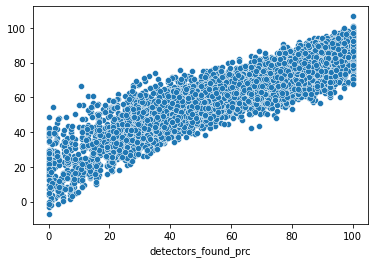

**Testing Performance**

Test RMSE: 14.931982928962187
Test MAE: 11.36208258614248


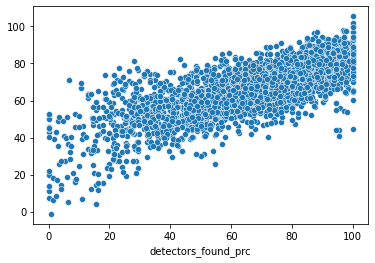

Test Correlation: (0.7416691505778157, 0.0)
Test R-squared: 0.536587472781177


**Feature Ranking**

1. RPL_THEME1 (0.214602)
2. RPL_THEME2 (0.116916)
3. RPL_THEME4 (0.112707)
4. RPL_THEME3 (0.109658)
5. Population Density (per square mile), 2010 (0.107959)
6. race_pct_black_or_amind (0.086700)
7. pct_alt_heat (0.069408)
8. house_yr_pct_before_1960 (0.063759)
9. inc_pct_poverty_x (0.048886)
10. did_not_work_past_12_mo (0.036041)
11. house_pct_live_alone (0.033364)
12. inc_pct_poverty_y (0.000000)


In [20]:
svi_use = True
smoke_prediction = Smoke.trainModels(ARC,ACS,SVI, ACS_cols_to_use,svi_use, utils.DATA['data'])

In [21]:
smoke_prediction

,num_surveys,detectors_found_total,detectors_found_prc,detectors_found_CI,detectors_working_total,detectors_working_prc,detectors_working_CI,geography,tract,Predictions,"Population Density (per square mile), 2010"
geoid,,,,,,,,,,,
010139534001,39,18.0,46.15,15.645969,12.0,30.77,14.485540,block_group,01013953400,48.474262,30.6
010139534002,48,19.0,39.58,13.834508,8.0,16.67,10.543965,block_group,01013953400,48.174011,30.6
010730023034,44,34.0,77.27,12.383258,19.0,43.18,14.635975,block_group,01073002303,67.423523,2370.0
010730035002,32,18.0,56.25,17.188239,8.0,25.00,15.003125,block_group,01073003500,59.589863,978.9
010730035003,34,23.0,67.65,15.724891,11.0,32.35,15.724891,block_group,01073003500,63.964989,978.9
...,...,...,...,...,...,...,...,...,...,...,...
560459511001,892,562.0,63.00,3.168435,347.0,38.90,3.199404,state,56045951100,70.296913,1.4
560459511002,892,562.0,63.00,3.168435,347.0,38.90,3.199404,state,56045951100,75.093887,1.4
560459513001,892,562.0,63.00,3.168435,347.0,38.90,3.199404,state,56045951300,72.075195,91.0


# Saving File

In [22]:
out = NFIRS.fires.copy()
out.columns =  'fires_per_1K_pop_' + out.columns
cols = out.columns

In [23]:
out = ACS.data.merge(out, how = 'left', left_index = True, right_index = True)
out = out[cols]

In [24]:
# Smoke Alarm model munging 


# add number of surveys recorded at the block level
num_surveys_block = Smoke.models['Block_Group']['num_surveys'].copy()
num_surveys_block.index = num_surveys_block.index.str[2:]


out['recorded_home_visits'] = num_surveys_block


# add the statistical model outputs 
Smoke_predicts = Smoke.models['MultiLevel'][
    [ 'detectors_working_prc','detectors_working_CI','geography']].copy()
Smoke_predicts.index = Smoke_predicts.index.str[2:]
out = out.merge(Smoke_predicts,how = 'left', left_index = True, right_index = True)

## add DL model to outputs
DL = pd.DataFrame(smoke_prediction['Population Density (per square mile), 2010'])
DL['detectors_predicted'] = smoke_prediction['Predictions'].copy()

out = out.merge(DL,how = 'left', left_index = True, right_index = True)

In [25]:
out['smoke_detector_risk_frac'] =  1 - out['detectors_predicted'] / 100
out['smoke_detector_risk_score'] =  out['smoke_detector_risk_frac'].rank(pct=True)
out[['smoke_detector_risk_frac','smoke_detector_risk_score']]

,smoke_detector_risk_frac,smoke_detector_risk_score
GEOID,,
010010201001,0.184218,0.176500
010010201002,0.198984,0.214362
010010202001,0.349579,0.668718
010010202002,0.352308,0.676149
010010203001,0.264615,0.407736
...,...,...
560459511001,0.297031,0.510014
560459511002,0.249061,0.358402
560459513001,0.279248,0.453793


In [26]:
# add final invidual predictors 

out['SVI_Theme_1'] = SVI.data['RPL_THEME1'].replace(-999.0, np.NaN)

out['fire_propensity_risk_score'] = FPM.test_prediction_probs[:,1]
out['fire_severity_risk_score'] = FSM.test_prediction_probs[:,1]



In [27]:
# Not weighting
#create and add final predictor 

out['CombinedRiskScore'] =  out.loc[:,['smoke_detector_risk_score',
                                       'SVI_Theme_1',
                                       'fire_propensity_risk_score',
                                       'fire_severity_risk_score'] ].mean(axis = 1,
                                                                          skipna = False )

In [28]:
out

,fires_per_1K_pop_2009,fires_per_1K_pop_2010,fires_per_1K_pop_2011,fires_per_1K_pop_2012,fires_per_1K_pop_2013,fires_per_1K_pop_2014,fires_per_1K_pop_2015,fires_per_1K_pop_2016,fires_per_1K_pop_2017,recorded_home_visits,...,detectors_working_CI,geography,"Population Density (per square mile), 2010",detectors_predicted,smoke_detector_risk_frac,smoke_detector_risk_score,SVI_Theme_1,fire_propensity_risk_score,fire_severity_risk_score,CombinedRiskScore
GEOID,,,,,,,,,,,,,,,,,,,,,
010010201001,1.342282,2.684564,NaN,NaN,NaN,NaN,NaN,1.342282,1.342282,0,...,1.089020,state,504.8,81.578194,0.184218,0.176500,0.3913,0.278164,0.816859,0.415706
010010201002,1.581028,0.790514,NaN,1.581028,0.790514,NaN,1.581028,0.790514,NaN,0,...,1.089020,state,504.8,80.101570,0.198984,0.214362,0.3913,0.079479,0.037421,0.180641
010010202001,1.047120,NaN,3.141361,NaN,1.047120,1.047120,1.047120,1.047120,NaN,0,...,1.089020,state,1682.5,65.042084,0.349579,0.668718,0.7065,0.678772,0.796419,0.712602
010010202002,2.832861,2.832861,2.832861,0.944287,0.944287,NaN,0.944287,NaN,3.777148,0,...,1.089020,state,1682.5,64.769157,0.352308,0.676149,0.7065,0.134161,0.301321,0.454533
010010203001,0.846024,1.269036,0.846024,0.423012,1.269036,0.423012,0.423012,0.846024,NaN,0,...,1.089020,state,1633.1,73.538513,0.264615,0.407736,0.5659,0.002346,0.002481,0.244616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560459511001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.372684,NaN,0,...,3.199404,state,1.4,70.296913,0.297031,0.510014,0.3925,0.268031,0.294215,0.366190
560459511002,0.632111,NaN,NaN,NaN,NaN,NaN,0.632111,NaN,NaN,0,...,3.199404,state,1.4,75.093887,0.249061,0.358402,0.3925,0.262987,0.359560,0.343362
560459513001,0.868810,NaN,0.868810,NaN,0.868810,0.868810,NaN,NaN,1.737619,3,...,3.199404,state,91.0,72.075195,0.279248,0.453793,0.5093,0.024417,0.661153,0.412166


In [29]:
display(Markdown('**Combined Risk Score Summary:**'))

out['CombinedRiskScore'].describe()

**Combined Risk Score Summary:**

count    216824.000000
mean          0.404494
std           0.211338
min           0.001657
25%           0.241339
50%           0.386180
75%           0.543973
max           0.993570
Name: CombinedRiskScore, dtype: float64

In [30]:
out

,fires_per_1K_pop_2009,fires_per_1K_pop_2010,fires_per_1K_pop_2011,fires_per_1K_pop_2012,fires_per_1K_pop_2013,fires_per_1K_pop_2014,fires_per_1K_pop_2015,fires_per_1K_pop_2016,fires_per_1K_pop_2017,recorded_home_visits,...,detectors_working_CI,geography,"Population Density (per square mile), 2010",detectors_predicted,smoke_detector_risk_frac,smoke_detector_risk_score,SVI_Theme_1,fire_propensity_risk_score,fire_severity_risk_score,CombinedRiskScore
GEOID,,,,,,,,,,,,,,,,,,,,,
010010201001,1.342282,2.684564,NaN,NaN,NaN,NaN,NaN,1.342282,1.342282,0,...,1.089020,state,504.8,81.578194,0.184218,0.176500,0.3913,0.278164,0.816859,0.415706
010010201002,1.581028,0.790514,NaN,1.581028,0.790514,NaN,1.581028,0.790514,NaN,0,...,1.089020,state,504.8,80.101570,0.198984,0.214362,0.3913,0.079479,0.037421,0.180641
010010202001,1.047120,NaN,3.141361,NaN,1.047120,1.047120,1.047120,1.047120,NaN,0,...,1.089020,state,1682.5,65.042084,0.349579,0.668718,0.7065,0.678772,0.796419,0.712602
010010202002,2.832861,2.832861,2.832861,0.944287,0.944287,NaN,0.944287,NaN,3.777148,0,...,1.089020,state,1682.5,64.769157,0.352308,0.676149,0.7065,0.134161,0.301321,0.454533
010010203001,0.846024,1.269036,0.846024,0.423012,1.269036,0.423012,0.423012,0.846024,NaN,0,...,1.089020,state,1633.1,73.538513,0.264615,0.407736,0.5659,0.002346,0.002481,0.244616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560459511001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.372684,NaN,0,...,3.199404,state,1.4,70.296913,0.297031,0.510014,0.3925,0.268031,0.294215,0.366190
560459511002,0.632111,NaN,NaN,NaN,NaN,NaN,0.632111,NaN,NaN,0,...,3.199404,state,1.4,75.093887,0.249061,0.358402,0.3925,0.262987,0.359560,0.343362
560459513001,0.868810,NaN,0.868810,NaN,0.868810,0.868810,NaN,NaN,1.737619,3,...,3.199404,state,91.0,72.075195,0.279248,0.453793,0.5093,0.024417,0.661153,0.412166


In [31]:
out_name = f"CombinedModels-basic{date.today()}.csv"
out_save = out.copy()
out_save.index = '#_' + out_save.index
out_save.to_csv(utils.DATA['model-outputs'] / out_name)

In [32]:
# alternate risk score ideas 

#out['CombinedRiskScore'] = (out[["fire_severity_risk_score", "fire_propensity_risk_score"]].max(axis=1) + out['smoke_detector_risk_score'])*100

In [33]:
out_columns = ['state','NFIRS_start','NFIRS_end','years_fires_reported','total_fires_reported', 'max_fires_1k', 
               'median_fires_1k','total_fires_reported_sev', 'max_fires_1k_sev', 'median_fires_1k_sev',
               'fire_propensity_risk_score','fire_severity_risk_score', 'recorded_home_visits',
              'smoke_detector_risk_frac', 'smoke_detector_risk_score','geography', 'SVI_Theme_1','CombinedRiskScore',
              'did_not_work_past_12_mo', 'house_pct_live_alone', 'pct_alt_heat', 'house_yr_pct_before_1960', 
               'inc_pct_poverty', 'race_pct_black_or_amind', 'tot_population', 'house_tot_occ_cnt', 'inc_pcincome', 
               'inc_hhmean', 'race_pct_white', 'race_pct_whitenh','race_pct_whiteh', 'race_pct_nwhitenh', 
               'race_pct_hisp',  'race_pct_black', 'race_pct_amind',  'race_pct_asian', 'race_pct_napi', 'race_pct_other', 
               'race_pct_two+','age_pct_under25', 'age_pct_over65',  'disability_pct', 'snap_past_12_mo', 'single_unit_home', 
               'multi_unit_home', 'mobile_home', 'boat_van_rv_home', 'spanish_speaking', 'state_id', 'state_rank', 'county_id', 'county_rank']
display(Markdown('**Saving columns:**'))
out_columns

**Saving columns:**

['state',
 'NFIRS_start',
 'NFIRS_end',
 'years_fires_reported',
 'total_fires_reported',
 'max_fires_1k',
 'median_fires_1k',
 'total_fires_reported_sev',
 'max_fires_1k_sev',
 'median_fires_1k_sev',
 'fire_propensity_risk_score',
 'fire_severity_risk_score',
 'recorded_home_visits',
 'smoke_detector_risk_frac',
 'smoke_detector_risk_score',
 'geography',
 'SVI_Theme_1',
 'CombinedRiskScore',
 'did_not_work_past_12_mo',
 'house_pct_live_alone',
 'pct_alt_heat',
 'house_yr_pct_before_1960',
 'inc_pct_poverty',
 'race_pct_black_or_amind',
 'tot_population',
 'house_tot_occ_cnt',
 'inc_pcincome',
 'inc_hhmean',
 'race_pct_white',
 'race_pct_whitenh',
 'race_pct_whiteh',
 'race_pct_nwhitenh',
 'race_pct_hisp',
 'race_pct_black',
 'race_pct_amind',
 'race_pct_asian',
 'race_pct_napi',
 'race_pct_other',
 'race_pct_two+',
 'age_pct_under25',
 'age_pct_over65',
 'disability_pct',
 'snap_past_12_mo',
 'single_unit_home',
 'multi_unit_home',
 'mobile_home',
 'boat_van_rv_home',
 'spanish_speak

In [34]:
years = FSM.years_used
years

array(['2011', '2012', '2013', '2014', '2015', '2016', '2017'],
      dtype=object)

In [35]:
out['NFIRS_start'] = min(years)
out['NFIRS_start'] = out['NFIRS_start'].astype(int)
out['NFIRS_end'] = max(years)
out['NFIRS_end'] = out['NFIRS_end'].astype(int)
out

,fires_per_1K_pop_2009,fires_per_1K_pop_2010,fires_per_1K_pop_2011,fires_per_1K_pop_2012,fires_per_1K_pop_2013,fires_per_1K_pop_2014,fires_per_1K_pop_2015,fires_per_1K_pop_2016,fires_per_1K_pop_2017,recorded_home_visits,...,"Population Density (per square mile), 2010",detectors_predicted,smoke_detector_risk_frac,smoke_detector_risk_score,SVI_Theme_1,fire_propensity_risk_score,fire_severity_risk_score,CombinedRiskScore,NFIRS_start,NFIRS_end
GEOID,,,,,,,,,,,,,,,,,,,,,
010010201001,1.342282,2.684564,NaN,NaN,NaN,NaN,NaN,1.342282,1.342282,0,...,504.8,81.578194,0.184218,0.176500,0.3913,0.278164,0.816859,0.415706,2011,2017
010010201002,1.581028,0.790514,NaN,1.581028,0.790514,NaN,1.581028,0.790514,NaN,0,...,504.8,80.101570,0.198984,0.214362,0.3913,0.079479,0.037421,0.180641,2011,2017
010010202001,1.047120,NaN,3.141361,NaN,1.047120,1.047120,1.047120,1.047120,NaN,0,...,1682.5,65.042084,0.349579,0.668718,0.7065,0.678772,0.796419,0.712602,2011,2017
010010202002,2.832861,2.832861,2.832861,0.944287,0.944287,NaN,0.944287,NaN,3.777148,0,...,1682.5,64.769157,0.352308,0.676149,0.7065,0.134161,0.301321,0.454533,2011,2017
010010203001,0.846024,1.269036,0.846024,0.423012,1.269036,0.423012,0.423012,0.846024,NaN,0,...,1633.1,73.538513,0.264615,0.407736,0.5659,0.002346,0.002481,0.244616,2011,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560459511001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.372684,NaN,0,...,1.4,70.296913,0.297031,0.510014,0.3925,0.268031,0.294215,0.366190,2011,2017
560459511002,0.632111,NaN,NaN,NaN,NaN,NaN,0.632111,NaN,NaN,0,...,1.4,75.093887,0.249061,0.358402,0.3925,0.262987,0.359560,0.343362,2011,2017
560459513001,0.868810,NaN,0.868810,NaN,0.868810,0.868810,NaN,NaN,1.737619,3,...,91.0,72.075195,0.279248,0.453793,0.5093,0.024417,0.661153,0.412166,2011,2017


In [36]:
fires_trained = NFIRS.fires_noAdjustment[years]
fires_trained2 = fires_trained>0
fires_trained2['years_fires_reported']= fires_trained2.sum(axis = 1)
fires_trained2 = fires_trained2['years_fires_reported']
out = out.merge(fires_trained2, how = 'left', left_index = True, right_index = True)

fires_trained = NFIRS.fires_noAdjustment[years]
fires_trained['total_fires_reported'] = fires_trained.sum(axis = 1)
fires_trained = fires_trained['total_fires_reported']
out = out.merge(fires_trained, how = 'left', left_index = True, right_index = True)

fires_trained = NFIRS.fires[years]
fires_trained2 = np.nanmax(fires_trained, axis =1)
fires_trained['max_fires_1k'] = fires_trained2
fires_trained2 = fires_trained['max_fires_1k']
out = out.merge(fires_trained2, how = 'left', left_index = True, right_index = True)

fires_trained = NFIRS.fires[years]
fires_trained2 = np.nanmedian(fires_trained, axis =1)
fires_trained['median_fires_1k'] = fires_trained2
fires_trained2 = fires_trained['median_fires_1k']
out = out.merge(fires_trained2, how = 'left', left_index = True, right_index = True)
out

,fires_per_1K_pop_2009,fires_per_1K_pop_2010,fires_per_1K_pop_2011,fires_per_1K_pop_2012,fires_per_1K_pop_2013,fires_per_1K_pop_2014,fires_per_1K_pop_2015,fires_per_1K_pop_2016,fires_per_1K_pop_2017,recorded_home_visits,...,SVI_Theme_1,fire_propensity_risk_score,fire_severity_risk_score,CombinedRiskScore,NFIRS_start,NFIRS_end,years_fires_reported,total_fires_reported,max_fires_1k,median_fires_1k
GEOID,,,,,,,,,,,,,,,,,,,,,
010010201001,1.342282,2.684564,NaN,NaN,NaN,NaN,NaN,1.342282,1.342282,0,...,0.3913,0.278164,0.816859,0.415706,2011,2017,2.0,2.0,1.342282,1.342282
010010201002,1.581028,0.790514,NaN,1.581028,0.790514,NaN,1.581028,0.790514,NaN,0,...,0.3913,0.079479,0.037421,0.180641,2011,2017,4.0,6.0,1.581028,1.185771
010010202001,1.047120,NaN,3.141361,NaN,1.047120,1.047120,1.047120,1.047120,NaN,0,...,0.7065,0.678772,0.796419,0.712602,2011,2017,5.0,7.0,3.141361,1.047120
010010202002,2.832861,2.832861,2.832861,0.944287,0.944287,NaN,0.944287,NaN,3.777148,0,...,0.7065,0.134161,0.301321,0.454533,2011,2017,5.0,10.0,3.777148,0.944287
010010203001,0.846024,1.269036,0.846024,0.423012,1.269036,0.423012,0.423012,0.846024,NaN,0,...,0.5659,0.002346,0.002481,0.244616,2011,2017,6.0,10.0,1.269036,0.634518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560459511001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.372684,NaN,0,...,0.3925,0.268031,0.294215,0.366190,2011,2017,1.0,2.0,1.372684,1.372684
560459511002,0.632111,NaN,NaN,NaN,NaN,NaN,0.632111,NaN,NaN,0,...,0.3925,0.262987,0.359560,0.343362,2011,2017,1.0,1.0,0.632111,0.632111
560459513001,0.868810,NaN,0.868810,NaN,0.868810,0.868810,NaN,NaN,1.737619,3,...,0.5093,0.024417,0.661153,0.412166,2011,2017,4.0,5.0,1.737619,0.868810


In [37]:
fires_trained = NFIRS_Sev.fires[years]
fires_trained['total_fires_reported_sev'] = fires_trained.sum(axis = 1)
fires_trained = fires_trained['total_fires_reported_sev']
out = out.merge(fires_trained, how = 'left', left_index = True, right_index = True)

fires_trained = NFIRS_Sev.fires[years]
fires_trained2 = np.nanmax(fires_trained, axis =1)
fires_trained['max_fires_1k_sev'] = fires_trained2
fires_trained2 = fires_trained['max_fires_1k_sev']
out = out.merge(fires_trained2, how = 'left', left_index = True, right_index = True)

fires_trained = NFIRS_Sev.fires[years]
fires_trained2 = np.nanmedian(fires_trained, axis =1)
fires_trained['median_fires_1k_sev'] = fires_trained2
fires_trained2 = fires_trained['median_fires_1k_sev']
out = out.merge(fires_trained2, how = 'left', left_index = True, right_index = True)
out

,fires_per_1K_pop_2009,fires_per_1K_pop_2010,fires_per_1K_pop_2011,fires_per_1K_pop_2012,fires_per_1K_pop_2013,fires_per_1K_pop_2014,fires_per_1K_pop_2015,fires_per_1K_pop_2016,fires_per_1K_pop_2017,recorded_home_visits,...,CombinedRiskScore,NFIRS_start,NFIRS_end,years_fires_reported,total_fires_reported,max_fires_1k,median_fires_1k,total_fires_reported_sev,max_fires_1k_sev,median_fires_1k_sev
GEOID,,,,,,,,,,,,,,,,,,,,,
010010201001,1.342282,2.684564,NaN,NaN,NaN,NaN,NaN,1.342282,1.342282,0,...,0.415706,2011,2017,2.0,2.0,1.342282,1.342282,2.684564,1.342282,1.342282
010010201002,1.581028,0.790514,NaN,1.581028,0.790514,NaN,1.581028,0.790514,NaN,0,...,0.180641,2011,2017,4.0,6.0,1.581028,1.185771,1.581028,0.790514,0.790514
010010202001,1.047120,NaN,3.141361,NaN,1.047120,1.047120,1.047120,1.047120,NaN,0,...,0.712602,2011,2017,5.0,7.0,3.141361,1.047120,2.094241,1.047120,1.047120
010010202002,2.832861,2.832861,2.832861,0.944287,0.944287,NaN,0.944287,NaN,3.777148,0,...,0.454533,2011,2017,5.0,10.0,3.777148,0.944287,2.832861,1.888574,1.416431
010010203001,0.846024,1.269036,0.846024,0.423012,1.269036,0.423012,0.423012,0.846024,NaN,0,...,0.244616,2011,2017,6.0,10.0,1.269036,0.634518,2.115059,0.423012,0.423012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560459511001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.372684,NaN,0,...,0.366190,2011,2017,1.0,2.0,1.372684,1.372684,1.372684,1.372684,1.372684
560459511002,0.632111,NaN,NaN,NaN,NaN,NaN,0.632111,NaN,NaN,0,...,0.343362,2011,2017,1.0,1.0,0.632111,0.632111,0.000000,NaN,NaN
560459513001,0.868810,NaN,0.868810,NaN,0.868810,0.868810,NaN,NaN,1.737619,3,...,0.412166,2011,2017,4.0,5.0,1.737619,0.868810,0.000000,NaN,NaN


In [38]:
ACS_toCombine = ACS.data
#check this makes sense
ACS_toCombine['inc_hhmean'] = ACS_toCombine['inc_pcincome']*ACS_toCombine['tot_population']/ACS_toCombine['house_tot_occ_cnt']
ACS_toCombine['inc_hhmean'] = ACS_toCombine['inc_hhmean'].round()
ACS_toCombine['race_pct_whiteh'] = ACS_toCombine['race_pct_white']-ACS_toCombine['race_pct_whitenh']
ACS_toCombine['race_pct_nwhitenh'] = 1-ACS_toCombine['race_pct_hisp']-ACS_toCombine['race_pct_whitenh']
ACS_toCombine['race_pct_nwhitenh'] = ACS_toCombine['race_pct_nwhitenh'].round(5)


ACS_keep = ACS_toCombine[['state',
    'did_not_work_past_12_mo', 'house_pct_live_alone', 'pct_alt_heat', 'house_yr_pct_before_1960', 
    'inc_pct_poverty', 'race_pct_black_or_amind', 'tot_population', 'house_tot_occ_cnt', 'inc_pcincome', 
    'inc_hhmean', 'race_pct_white', 'race_pct_whitenh','race_pct_whiteh', 'race_pct_nwhitenh', 
    'race_pct_hisp',  'race_pct_black', 'race_pct_amind',  'race_pct_asian', 'race_pct_napi', 'race_pct_other', 
    'race_pct_two+','age_pct_under25', 'age_pct_over65',  'disability_pct', 'snap_past_12_mo', 'single_unit_home', 
    'multi_unit_home', 'mobile_home', 'boat_van_rv_home', 'spanish_speaking'
    ]]
ACS_keep = ACS_keep.replace(-666666666.0, np.nan)
ACS_keep = ACS_keep.replace(np.inf, np.nan)

In [39]:
out = out.merge(ACS_keep, how = 'left', left_index = True, right_index = True)
out

,fires_per_1K_pop_2009,fires_per_1K_pop_2010,fires_per_1K_pop_2011,fires_per_1K_pop_2012,fires_per_1K_pop_2013,fires_per_1K_pop_2014,fires_per_1K_pop_2015,fires_per_1K_pop_2016,fires_per_1K_pop_2017,recorded_home_visits,...,race_pct_two+,age_pct_under25,age_pct_over65,disability_pct,snap_past_12_mo,single_unit_home,multi_unit_home,mobile_home,boat_van_rv_home,spanish_speaking
GEOID,,,,,,,,,,,,,,,,,,,,,
010010201001,1.342282,2.684564,NaN,NaN,NaN,NaN,NaN,1.342282,1.342282,0,...,0.000000,0.363758,0.036242,0.239437,0.183099,0.820423,0.024648,0.154930,0.000000,0.102113
010010201002,1.581028,0.790514,NaN,1.581028,0.790514,NaN,1.581028,0.790514,NaN,0,...,0.054545,0.348617,0.114625,0.278509,0.096491,0.925054,0.000000,0.074946,0.000000,0.046053
010010202001,1.047120,NaN,3.141361,NaN,1.047120,1.047120,1.047120,1.047120,NaN,0,...,0.018750,0.372917,0.161458,0.458549,0.303109,0.768844,0.201005,0.030151,0.000000,0.000000
010010202002,2.832861,2.832861,2.832861,0.944287,0.944287,NaN,0.944287,NaN,3.777148,0,...,0.012945,0.303398,0.094660,0.280973,0.172566,0.821138,0.168699,0.010163,0.000000,0.011062
010010203001,0.846024,1.269036,0.846024,0.423012,1.269036,0.423012,0.423012,0.846024,NaN,0,...,0.035956,0.302876,0.134095,0.379854,0.082524,0.995112,0.000000,0.004888,0.000000,0.037621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560459511001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.372684,NaN,0,...,0.049417,0.234043,0.175704,0.219941,0.054252,0.711035,0.053470,0.228669,0.006826,0.000000
560459511002,0.632111,NaN,NaN,NaN,NaN,NaN,0.632111,NaN,NaN,0,...,0.004849,0.208513,0.215517,0.276139,0.010724,0.706250,0.000000,0.293750,0.000000,0.009383
560459513001,0.868810,NaN,0.868810,NaN,0.868810,0.868810,NaN,NaN,1.737619,3,...,0.000000,0.325804,0.076455,0.210325,0.172084,0.709910,0.054054,0.236036,0.000000,0.000000


In [40]:
out['state_id'] = out.index
out['state_id'] = out['state_id'].str[:2]
out['state_rank'] = out.groupby('state_id')['CombinedRiskScore'].rank(ascending=False)
out['county_id'] = out.index
out['county_id'] = out['county_id'].str[:5]
out['county_rank'] = out.groupby('county_id')['CombinedRiskScore'].rank(ascending=False)

In [41]:
out_final = out[out_columns]
out_final

,state,NFIRS_start,NFIRS_end,years_fires_reported,total_fires_reported,max_fires_1k,median_fires_1k,total_fires_reported_sev,max_fires_1k_sev,median_fires_1k_sev,...,snap_past_12_mo,single_unit_home,multi_unit_home,mobile_home,boat_van_rv_home,spanish_speaking,state_id,state_rank,county_id,county_rank
GEOID,,,,,,,,,,,,,,,,,,,,,
010010201001,AL,2011,2017,2.0,2.0,1.342282,1.342282,2.684564,1.342282,1.342282,...,0.183099,0.820423,0.024648,0.154930,0.000000,0.102113,01,2189.0,01001,17.0
010010201002,AL,2011,2017,4.0,6.0,1.581028,1.185771,1.581028,0.790514,0.790514,...,0.096491,0.925054,0.000000,0.074946,0.000000,0.046053,01,3155.0,01001,27.0
010010202001,AL,2011,2017,5.0,7.0,3.141361,1.047120,2.094241,1.047120,1.047120,...,0.303109,0.768844,0.201005,0.030151,0.000000,0.000000,01,633.0,01001,2.0
010010202002,AL,2011,2017,5.0,10.0,3.777148,0.944287,2.832861,1.888574,1.416431,...,0.172566,0.821138,0.168699,0.010163,0.000000,0.011062,01,1948.0,01001,11.0
010010203001,AL,2011,2017,6.0,10.0,1.269036,0.634518,2.115059,0.423012,0.423012,...,0.082524,0.995112,0.000000,0.004888,0.000000,0.037621,01,2972.0,01001,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560459511001,WY,2011,2017,1.0,2.0,1.372684,1.372684,1.372684,1.372684,1.372684,...,0.054252,0.711035,0.053470,0.228669,0.006826,0.000000,56,167.0,56045,3.0
560459511002,WY,2011,2017,1.0,1.0,0.632111,0.632111,0.000000,NaN,NaN,...,0.010724,0.706250,0.000000,0.293750,0.000000,0.009383,56,194.0,56045,4.0
560459513001,WY,2011,2017,4.0,5.0,1.737619,0.868810,0.000000,NaN,NaN,...,0.172084,0.709910,0.054054,0.236036,0.000000,0.000000,56,114.0,56045,2.0


In [42]:
a = out.describe()
a.to_csv(utils.DATA['model-outputs']/f"summary-pop0-{date.today()}.csv")

In [43]:
out_name = f"CombinedModels-FileStructureColumns-pop0-{date.today()}.csv"
out_final.index = '#_' + out_final.index
out_final.to_csv(utils.DATA['model-outputs'] / out_name)